# Workflow (Part II)
In prvious notebook, we've shown two workflow patterns namely prompt chaining and parallelization. Here, we focus on two of the patterns namely:

- Routing
- Orchestrator-Worker
- Evaluator-optimizer

## LLM Setup
For the following notebooks, we use LangGraph along Anthropic API.

In [1]:
# Required Modules

import sys
import os
import logging
import platform
from datetime import date, datetime

from dotenv import load_dotenv

from langchain_anthropic import ChatAnthropic
from pydantic import BaseModel, Field

# Modules used for prompt chaining
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display


print(f"  System: {sys.platform}")
print(f"  Platform: {platform.platform()}")
print(f"  Python version: {platform.python_version()}")
print(f"  System Execution (Python) path: {'/'.join(sys.executable.strip('/').split('/')[-3:])}")
print(f"  Last update: {date.today().strftime('%Y-%m-%d')}")

  System: darwin
  Platform: macOS-15.5-arm64-arm-64bit
  Python version: 3.11.12
  System Execution (Python) path: .venv/bin/python
  Last update: 2025-05-22


In [2]:
# Configure logging
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

In [3]:
def _set_env(var: str):
    load_dotenv()  # Load variables from .env into os.environ
    if not os.environ.get(var):
        raise EnvironmentError(f"Environment variable '{var}' not found. Please set it in .env")
    else:
        logger.info(f"Environment variable '{var}' is loaded.")

# Load 
_set_env("ANTHROPIC_API_KEY")

model = "claude-3-5-sonnet-latest"
llm = ChatAnthropic(model=model)
logger.info(f"LLM model object is built wih '{model}'.")

2025-05-22 13:20:22,387 - __main__ - INFO - Environment variable 'ANTHROPIC_API_KEY' is loaded.
2025-05-22 13:20:22,389 - __main__ - INFO - LLM model object is built wih 'claude-3-5-sonnet-latest'.


# Routing
Routing classifies an input and directs it to a specialized followup task.

- E.g., when routing a question to different retrieval systems.


<div style="text-align: center;">
   <img src="images/routing.webp" alt="Sample Image" width="60%">
</div>

**Note**: If you notice, the connections are dashe-lines except one. This indicates different pass through the router to differenct LLM calls.

## Example:

- Route an input between joke, story, and poem

## Router
Since we want to use routing workflow pattern, we need to define the router along with what kinds of inputs are allowed. The following is an example of how we can define such structure for the routing


In [4]:
from typing_extensions import Literal

# Schema for structured output to use as routing logic
class Route(BaseModel):
    step: Literal["poem", "story", "joke"] = Field(
        None, description="The next step in the routing process"
    )

# Augment the LLM with schema for structured output
router = llm.with_structured_output(Route)

## Structured Output
In the first step, we need to define what is expected as teh state of the workflow:

- input: String type
- decision: String type
- output: String type

In [5]:
# Schema for structured output
# Graph state
class State(TypedDict):
    input: str
    decision: str
    output: str

## Node Functions
In the next step we need to build the functions associated with the nodes in the workflow. Each function is responsible for certain task defined in the work flow


In [6]:
from langchain_core.messages import HumanMessage, SystemMessage

# Nodes
def llm_call_1(state: State):
    """Write a story"""

    print("Write a story")
    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_2(state: State):
    """Write a joke"""

    print("Write a joke")
    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_3(state: State):
    """Write a poem"""

    print("Write a poem")
    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_router(state: State):
    """Route the input to the appropriate node"""

    # Run the augmented LLM with structured output to serve as routing logic
    decision = router.invoke(
        [
            SystemMessage(
                content="Route the input to story, joke, or poem based on the user's request."
            ),
            HumanMessage(content=state["input"]),
        ]
    )

    return {"decision": decision.step}

# Conditional edge function to route to the appropriate node
def route_decision(state: State):
    # Return the node name you want to visit next
    if state["decision"] == "story":
        return "llm_call_1"
    elif state["decision"] == "joke":
        return "llm_call_2"
    elif state["decision"] == "poem":
        return "llm_call_3"

## Workflow
Once we built the nodes, now it's time to connect them. To this end, we use a special module called ``StateGraph`` which allows you to:

- Modularize your logic.
- Chain stateful operations.
- Ensure type safety with ``Pydantic`` or ``TypedDict``.
- Integrate tools or LLM calls into a consistent framework.

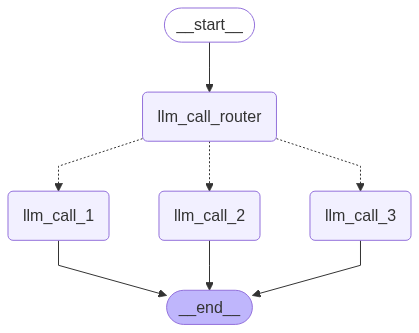

In [7]:

# Build workflow
router_builder = StateGraph(State)

# Add nodes
router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)
router_builder.add_node("llm_call_router", llm_call_router)

# Add edges to connect nodes
router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "llm_call_1": "llm_call_1",
        "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3",
    },
)
router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)

# Compile workflow
router_workflow = router_builder.compile()

# Show the workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))

In [8]:
state = router_workflow.invoke({"input": "Write me a joke about cats"})
print(state["output"])

2025-05-22 13:20:23,506 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"


Write a joke


2025-05-22 13:20:24,939 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"


Here's a cat joke for you:

Why don't cats like online shopping?

They prefer a cat-alog!


In [9]:
state = router_workflow.invoke({"input": "Write me a poem about cats"})
print(state["output"])

2025-05-22 13:20:26,409 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"


Write a poem


2025-05-22 13:20:30,778 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"


Here's a poem about cats:

Soft paws and whiskers, graceful and light,
Prowling through shadows in the night.
Golden eyes that gleam and glow,
Watching movements high and low.

Purring softly on a lap,
Curled up taking peaceful naps.
Independent, proud, and free,
Yet loving when they choose to be.

Masters of the windowsill,
Hunting skills with perfect skill.
Leaping, climbing, oh so spry,
Curious about each butterfly.

Velvet fur and pointed ears,
Silent stalkers, knowing no fears.
Ancient spirits, nine lives blessed,
Of all pets, perhaps the best.


# Orchestrator-Worker
Orchestrator breaks down a task and delegates each sub-task to workers as shown in the figure. It's similar with parallelization but the difference is that here the LLM creates as many workers as needed based on the reasoning.

- E.g., planning a report where LLM can determine the number of sections.


<div style="text-align: center;">
   <img src="images/orchestrator.webp" alt="Sample Image" width="60%">
</div>

**Note**: If you noticed, all the edges are dashed-lines. This indicates that all the edges will be uses by the orchestrator in parallel.



## Example

- Take a topic, plan a report of section, have each worker write a section

The way we need to treat this workflow pattern is different. The goal is to generate a well-structured report by dividing the task into planning, parallel content generation, and synthesis, so we need to define different components along with Workflow Nodes.

### Components
1. Schemas for Structured Planning
   - These schemas define the structure of the report plan. The LLM uses them to generate a list of sections.
2. State Definitions
   - These typed dictionaries define the shared state and worker-specific state. ``completed_sections`` uses operator ``.add`` to merge results from parallel workers.
3. Planner Setup
   - The planner LLM is wrapped to return structured Sections output. Basiclly the planner creates as many sections based on its reflection.

In [10]:
from typing import Annotated, List
import operator

# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )


class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )

# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)

# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report

# Worker state
# We want each worker has its own state like each section is handled by a worker
# and the final report is a combination of all sections. This can be seen by using
# the `completed_sections` key in the state. Cool thing about this abstration in
# LangGraph is that we can use the completed_sections key in the state to
# combine all sections in parallel. This is done by using the `operator.add` function
# in the `completed_sections` key.
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]

### Workflow Nodes
1. Orchestrator: Generates the section plan based on the topic.
2. Worker (``llm_call``): Each worker writes one section of the report.
3. Synthesizer: Combines all completed sections into a final report.
   - Edge Logic: Assign Workers Conditionally

In [11]:
from langgraph.constants import Send
# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    return {"sections": report_sections.sections}


def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(content="Write a report section."),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}


def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}


# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]

### Workflow Builder

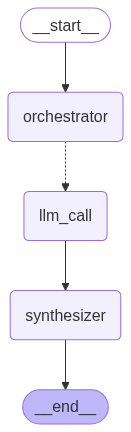

In [12]:
# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

In [13]:
state = orchestrator_worker.invoke({"topic": "Create a report on LLM scaling laws"})


2025-05-22 13:20:38,560 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-22 13:20:49,517 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-22 13:20:50,263 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-22 13:20:51,402 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-22 13:20:53,715 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-22 13:20:54,227 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-22 13:20:54,724 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-22 13:20:54,940 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-22 13:20:55,865 - httpx - INFO - HTTP Request: POST https://api.

In [14]:
from IPython.display import Markdown

Markdown(state["final_report"])

Here's a draft report section on LLM Scaling laws:

Introduction to LLM Scaling Laws

Scaling laws for Large Language Models (LLMs) represent empirically observed relationships between model performance and key parameters such as model size, dataset size, and computational resources. These mathematical relationships have become fundamental to understanding how language models improve as they are made larger and trained on more data.

The most important scaling laws show that model performance (typically measured by loss or perplexity) improves smoothly and predictably as compute and data resources increase, following power-law relationships. Specifically, performance tends to improve:

- As model size (number of parameters) increases
- As training dataset size increases  
- As total training compute increases

The practical significance of scaling laws cannot be overstated. They allow researchers and organizations to:

1. Make informed decisions about resource allocation for training
2. Predict performance improvements from increased scale
3. Understand fundamental trade-offs between model size, data, and compute
4. Project future capabilities of language models

Key findings from scaling law research include:

- Performance improvements follow a power-law curve with diminishing returns
- Larger models are generally more sample-efficient than smaller models
- There appears to be no fundamental ceiling yet in sight for performance gains from scaling
- Optimal allocation of compute between model size and training tokens follows predictable patterns

These relationships were first systematically studied by OpenAI researchers in 2020, who found that model performance improved smoothly and predictably across multiple orders of magnitude. Subsequent research has largely confirmed and refined these initial findings.

Understanding scaling laws is crucial for:

- Research planning and resource allocation
- Forecasting AI capabilities and development timelines
- Identifying potential limitations and bottlenecks
- Informing policy and safety discussions around AI development

While current scaling laws have proven remarkably robust, there remain important open questions about:

- Whether these relationships will continue to hold at even larger scales
- The existence of potential fundamental limits to scaling
- How scaling behavior might differ for new architectures or training approaches
- The relationship between scale and specific capabilities or emergent behaviors

As the field of AI continues to advance rapidly, scaling laws provide an essential framework for understanding and predicting how language models will develop with increased resources and improved techniques.

---

Here's a draft report section on Fundamental Scaling Relationships:

Fundamental Scaling Relationships
================================

The scaling behavior of large language models (LLMs) follows several key mathematical relationships that govern how model performance improves with increases in computation, model size, and dataset size. Understanding these fundamental scaling laws is crucial for predicting performance improvements and making informed decisions about model architecture and training.

Computation Scaling
------------------

The relationship between compute and model performance follows a power-law scaling curve, first documented by OpenAI researchers. For language models, performance (measured by cross-entropy loss) improves according to:

L(C) ≈ (C₀/C)^α

where:
- L is the loss
- C is the compute used
- C₀ is a constant
- α is the scaling exponent (typically 0.05-0.1)

This relationship holds across multiple orders of magnitude of compute, though returns gradually diminish at extreme scales.

Model Size Scaling
-----------------

Model size scaling follows a similar power-law relationship. Performance improves with model parameter count according to:

L(N) ≈ (N₀/N)^β 

where:
- N is the number of model parameters
- N₀ is a constant
- β is the scaling exponent (typically 0.075-0.09)

This scaling continues until models become compute or data bound, though larger models generally require more compute and data to train effectively.

Dataset Size Scaling
-------------------

The relationship between dataset size and model performance follows:

L(D) ≈ (D₀/D)^γ

where:
- D is the dataset size
- D₀ is a constant
- γ is the scaling exponent (typically 0.095-0.115)

Notably, dataset requirements grow superlinearly with model size - larger models need proportionally more data to achieve optimal performance.

Interconnected Scaling Dimensions
-------------------------------

These three scaling dimensions - compute, model size, and data - are fundamentally interconnected. Optimal scaling requires balancing all three factors:

1. Compute requirements scale approximately cubically with model size
2. Data requirements scale approximately linearly with model size
3. Training time scales linearly with dataset size

This leads to the "scaling laws triangle" where improvements in any dimension must be balanced by corresponding increases in the others for optimal performance.

Practical Implications
---------------------

Understanding these scaling relationships has several practical implications:

1. Performance improvements from scaling are predictable but require exponentially more resources
2. There are diminishing returns in all scaling dimensions
3. Balanced scaling across compute, model size, and data is optimal
4. Cost-effective scaling requires carefully choosing which dimension to prioritize

Emerging Scaling Phenomena
-------------------------

Recent research has identified several important phenomena that emerge at scale:

1. Grokking - sudden performance improvements after extended training
2. Emergence of capabilities at specific scale thresholds
3. Scaling-induced changes in model behavior and capabilities

These observations suggest that simple power-law scaling relationships may not capture all aspects of model scaling, particularly at the frontier of model size and capability.

Future Considerations
-------------------

As models continue to scale, several key questions remain:

1. Whether current scaling laws will continue to hold at ever-larger scales
2. The ultimate limits of performance improvements from scaling
3. How architectural innovations might change fundamental scaling relationships
4. The role of data quality versus quantity in scaling behavior

Understanding these fundamental scaling relationships is essential for predicting future developments in language models and making informed decisions about resource allocation in model development.

This section provides a mathematical framework for understanding how language models improve with scale and highlights the practical implications of these relationships for model development and deployment.

---

Here's a draft report section on Chinchilla Scaling Laws:

# Chinchilla Scaling Laws

DeepMind's Chinchilla paper (Hoffmann et al., 2022) provided crucial insights into the optimal relationship between model size and training compute that has significantly influenced how large language models are trained. The paper's key finding was that many previous models were significantly undertrained relative to their size.

## Key Findings

The research demonstrated that for a fixed compute budget, the optimal allocation between model size and training tokens differs substantially from previous assumptions. Specifically, the paper found that:

- Models should be trained on approximately 20x more tokens than their parameter count
- Previous models like GPT-3 were "overparametrized" relative to their training data
- Smaller models trained on more data often outperform larger models trained on less data

## Optimal Scaling Relationships

The Chinchilla scaling laws describe the following relationships for compute-optimal training:

N (optimal number of parameters) ∝ C^0.5
D (optimal training tokens) ∝ C^0.5

Where C is the compute budget. This means that as compute increases, both model size and training tokens should increase proportionally with the square root of compute.

## Practical Implications

These findings have important practical implications for model training:

1. Resource Efficiency: Following Chinchilla scaling laws allows more efficient use of computational resources by properly balancing model size and training data

2. Cost Optimization: Organizations can achieve better performance by focusing on data quantity rather than just increasing model size

3. Training Strategy: The laws suggest that iterating on smaller models with more training data may be more productive than scaling to extremely large models

## Impact on Recent Models

The Chinchilla findings have influenced the training of several recent language models:

- Claude and GPT-4 reportedly incorporate lessons from Chinchilla scaling
- Many newer models use significantly more training tokens relative to their parameter count
- Some organizations have shifted focus toward data quality and quantity rather than just model size

## Limitations and Considerations

While highly influential, there are some important caveats to consider:

- The laws may not hold perfectly across all scales and architectures
- Data quality remains a crucial factor not fully captured by the scaling laws
- The relationship between model performance and human values/safety is not addressed
- The laws focus on autoregressive language models specifically

## Future Implications

The Chinchilla scaling laws continue to influence the field in several ways:

1. Dataset Creation: Increased focus on creating larger, higher-quality training datasets

2. Training Approaches: Development of more efficient training methods that maximize data exposure

3. Resource Allocation: Better planning of compute resources across model size and training data

4. Research Direction: Greater emphasis on understanding optimal training regimes rather than just scaling up model size

## Conclusion

The Chinchilla scaling laws represent a significant advance in our understanding of how to train large language models efficiently. They suggest that many previous models were not trained optimally and provide clear guidance for more efficient allocation of computational resources. These insights continue to influence both research and commercial development of language models.

For organizations developing language models, these findings emphasize the importance of carefully considering the balance between model size and training data, rather than simply pursuing larger models. This has implications for resource allocation, data collection strategies, and overall approach to model development.

---

This section provides a comprehensive overview of the Chinchilla scaling laws, their implications, and their impact on the field. The structure moves from core findings to practical implications and future considerations, making it accessible while maintaining technical accuracy.

---

Here's a draft of the Empirical Evidence and Observations section:

Empirical Evidence and Observations

The emergence of scaling laws in language models has been consistently demonstrated through empirical observations across multiple research organizations and model families. This section examines key evidence from prominent model series that have helped establish and validate these scaling relationships.

GPT Series (OpenAI)
The GPT family of models has provided some of the most comprehensive evidence for scaling laws. From GPT-2 to GPT-3, OpenAI documented clear performance improvements that followed predictable patterns with increased model size and compute:

- GPT-3 (175B parameters) showed consistent improvements across tasks compared to GPT-2 (1.5B parameters), with performance scaling roughly logarithmically with parameter count
- Zero-shot and few-shot capabilities emerged more prominently at larger scales
- Training compute requirements scaled with model size according to the relationship compute ∝ parameters^0.7

PaLM (Google)
Google's Pathways Language Model (PaLM) series provided additional validation:

- Performance improvements from 8B to 62B to 540B parameters followed predicted scaling curves
- Demonstrated improved sample efficiency at larger scales
- Showed emergent capabilities appearing at specific scale thresholds
- Confirmed earlier findings about compute-optimal model sizing

Chinchilla (DeepMind)
DeepMind's Chinchilla research revealed important insights about optimal scaling:

- Demonstrated that many previous models were undertrained relative to their size
- Established new compute-optimal scaling laws balancing model size and training tokens
- Showed performance improvements from training longer on fewer parameters versus larger models trained less

Other Notable Observations

- Anthropic's Constitutional AI models demonstrated scaling laws hold even with alignment constraints
- Meta's LLaMA series showed efficient scaling with architectural improvements
- Multiple labs have confirmed the emergence of capabilities at specific threshold scales

Common Patterns Across Studies

Several consistent patterns emerge from the empirical evidence:

1. Log-linear scaling of performance with compute and parameter count
2. Predictable compute requirements for training
3. Emergence of new capabilities at scale thresholds
4. Trade-offs between model size and training tokens
5. Consistency across different architectures and training approaches

Limitations and Caveats

While scaling laws show remarkable consistency, some important limitations have been observed:

- Scaling curves eventually show diminishing returns
- Different tasks may scale at different rates
- Architecture choices can shift but not fundamentally alter scaling patterns
- Data quality becomes increasingly important at larger scales

Future Research Directions

Current empirical evidence suggests several key areas for further investigation:

- Scaling behavior beyond current largest models
- Impact of architectural innovations on scaling laws
- Role of data quality and diversity in scaling
- Emergence of new capabilities at larger scales

The extensive empirical evidence from multiple independent sources provides strong validation for the existence and reliability of scaling laws in language models. These observations have proven invaluable for research planning and resource allocation in the field, though important questions remain about their ultimate limits and optimal application.

---

Here's a draft report section on Economic and Computational Implications:

Economic and Computational Implications

The emergence of scaling laws in artificial intelligence has profound implications for the economics and computational requirements of AI development. This section examines how these mathematical relationships impact training costs, computational resources, and strategic planning in AI research and deployment.

Training Cost Considerations

The relationship between model size, compute requirements, and performance follows predictable scaling laws that directly affect training costs. Key factors include:

- Computing infrastructure costs that grow approximately linearly with model size
- Energy consumption that increases substantially with larger models
- Data storage and preprocessing requirements that scale with training dataset size
- Human resources needed for model development and oversight

Current estimates suggest that training a large language model can cost anywhere from hundreds of thousands to millions of dollars, with costs increasing exponentially for state-of-the-art models.

Computational Resource Requirements

Scaling laws indicate that computational demands grow predictably but steeply:

- GPU/TPU requirements increase proportionally with model parameters
- Memory requirements scale both with model size and batch size
- Network bandwidth needs grow with distributed training approaches
- Storage requirements expand with larger training datasets

These relationships create practical upper bounds on model sizes given current hardware limitations and economic constraints.

Resource Allocation Strategy

Organizations must carefully consider how to allocate limited resources:

1. Hardware Investment
- Strategic decisions between purchasing vs. cloud computing
- Planning for future infrastructure needs
- Balancing capacity across training and inference

2. Research Direction
- Evaluating tradeoffs between model size and efficiency
- Investing in architectural innovations vs. scaling existing approaches
- Prioritizing specific capabilities or applications

3. Operational Planning
- Managing computing cluster utilization
- Scheduling training runs efficiently
- Maintaining appropriate backup and redundancy

Efficiency Improvements

Several approaches can help optimize resource utilization:

- Model compression and distillation techniques
- Mixed precision training
- Efficient architecture design
- Better preprocessing and data management
- Advanced parallelization strategies

Future Considerations

Looking ahead, several factors will influence economic and computational requirements:

- Advances in hardware efficiency
- Improvements in training algorithms
- New architectural approaches
- Changes in energy costs
- Evolution of cloud computing pricing

Implications for Industry

The economic and computational demands of AI scaling create important strategic considerations:

- Market concentration among well-resourced organizations
- Barriers to entry for smaller players
- Opportunities for specialized hardware and infrastructure providers
- Need for sustainable approaches to AI development

Risk Management

Organizations must consider several risks:

- Failed training runs representing significant sunk costs
- Hardware obsolescence
- Energy price volatility
- Regulatory changes affecting compute usage
- Environmental impact considerations

Recommendations

To effectively manage economic and computational implications:

1. Develop clear scaling strategies aligned with organizational goals
2. Maintain flexible infrastructure that can adapt to changing requirements
3. Invest in efficiency improvements and optimization
4. Monitor and forecast resource needs
5. Consider environmental impact and sustainability
6. Build redundancy into critical systems

Conclusion

Understanding and managing the economic and computational implications of AI scaling laws is crucial for successful AI development. Organizations must carefully balance ambitious goals with practical constraints while planning for future needs and challenges. This requires ongoing attention to efficiency, strategic resource allocation, and risk management.

---

Here's a draft of the Limitations and Criticisms section:

Limitations and Criticisms

While scaling laws have provided valuable insights into AI system behavior and development, they face several important limitations and critiques that warrant careful examination. This section explores key challenges to current scaling approaches and their underlying assumptions.

Fundamental Limitations

- Data Quality vs. Quantity: Scaling laws typically focus on dataset size but may not adequately account for data quality, relevance, and diversity. Simply increasing data volume does not necessarily translate to proportional improvements in model capabilities.

- Computational Constraints: Physical and economic limitations on computing resources create practical bounds for scaling. Energy consumption and hardware requirements grow substantially with model size, making indefinite scaling unsustainable.

- Diminishing Returns: Most scaling laws show diminishing returns as models grow larger, suggesting potential upper limits to performance improvements achievable through scaling alone.

Questionable Assumptions

- Smooth Scaling Behavior: Current laws often assume continuous, predictable relationships between model size and performance. However, emerging research suggests possible discontinuities and phase transitions in scaling behavior.

- Architecture Independence: Scaling laws typically assume results generalize across architectural choices, but different architectures may scale differently or hit limitations at different points.

- Task Generalization: The assumption that scaling benefits observed on specific tasks will generalize to other capabilities or domains remains contested.

Emerging Criticisms

- Environmental Impact: The massive energy consumption and carbon footprint of training ever-larger models raises serious sustainability concerns.

- Resource Concentration: The computational requirements for scaling create barriers to entry, potentially concentrating AI development among wealthy organizations.

- Oversight Challenges: Larger models become increasingly difficult to interpret, audit, and control, raising concerns about safety and accountability.

- Alternative Approaches: Critics argue that focusing on scaling diverts attention and resources from potentially more promising approaches like architectural innovation or specialized training methods.

Methodological Concerns

- Measurement Issues: Performance metrics used in scaling studies may not capture important aspects of model capability or reliability.

- Reproducibility: The resources required for large-scale experiments make independent verification challenging.

- Selection Bias: Published scaling results may suffer from publication bias toward successful scaling attempts.

Future Considerations

The limitations and criticisms of current scaling laws suggest several important directions for future research:

- Development of more nuanced scaling laws that account for data quality and architectural differences
- Investigation of alternative approaches to improving AI capabilities
- Methods for better measuring and predicting scaling behavior
- Sustainable scaling strategies that consider environmental and economic impacts
- Techniques for maintaining interpretability and control as models scale

These limitations and criticisms highlight the importance of maintaining a balanced perspective on scaling as one of many approaches to advancing AI capabilities, rather than viewing it as a complete solution to AI development challenges.

---

Here's a draft report section on Future Directions:

Future Directions

The field of AI scaling laws research, while already yielding valuable insights, has numerous promising avenues for future exploration and development. This section outlines several key directions that warrant further investigation.

Expanded Metrics and Relationships

Future research should explore additional metrics beyond the commonly studied loss and accuracy measurements. Potential areas include:
- Robustness metrics and their scaling behavior
- Generalization capabilities across different domains
- Sample efficiency and data utilization rates
- Energy efficiency and computational costs
- Model calibration and uncertainty quantification

Integration with Other Research Areas

Scaling laws research could benefit from stronger connections to:
- Theoretical computer science and complexity theory
- Information theory and compression
- Cognitive science and neuroscience
- Statistical physics and emergent phenomena

Novel Architectural Considerations

As architecture designs continue to evolve, new scaling relationships may emerge for:
- Mixture-of-experts architectures
- Sparse models and conditional computation
- Multi-modal architectures
- Hybrid neural-symbolic systems

Practical Applications

Future work should focus on translating scaling laws into actionable insights for:
- Resource allocation and infrastructure planning
- Model design and architecture selection
- Training strategy optimization
- Cost-benefit analysis of model scaling decisions

Methodological Improvements

Several methodological advances could enhance scaling laws research:
- More rigorous statistical frameworks
- Improved experimental designs
- Better tools for measuring and analyzing scaling behavior
- Standardized benchmarks and metrics

Emerging Challenges

Future research must address several key challenges:
- Understanding the limits of current scaling trends
- Identifying potential disruptions to established patterns
- Accounting for hardware evolution and constraints
- Incorporating environmental and societal impacts

Cross-Domain Applications

Scaling laws research could expand into new domains:
- Biological neural networks
- Scientific computing and simulation
- Robotics and embodied AI
- Social systems and collective intelligence

Long-term Implications

Future work should examine broader implications including:
- Ultimate limits to scaling
- Emergence of new capabilities
- Economic and societal impacts
- Ethical considerations and governance

The future of scaling laws research holds significant promise for advancing our understanding of artificial intelligence systems and their development. By pursuing these directions, researchers can continue to build a more comprehensive and nuanced understanding of how AI systems scale and evolve.

---

Here's a draft report section on Conclusions and Implications of AI Scaling Laws:

Conclusion and Future Implications of AI Scaling Laws

This section summarizes the key findings regarding AI scaling laws and examines their broader implications for the future development of artificial intelligence systems.

Key Findings:

1. Consistent Scaling Patterns
- Machine learning models demonstrate remarkably consistent performance improvements with increases in compute, data, and model size
- These improvements typically follow power-law relationships
- Scaling behavior appears robust across different model architectures and tasks

2. Resource Requirements
- Performance gains require exponential increases in computational resources
- Data requirements grow substantially with model size
- Energy and infrastructure costs scale proportionally with compute demands

3. Current Limitations
- Scaling alone cannot address all AI challenges
- Diminishing returns eventually emerge in most scaling relationships
- Some capabilities appear to require architectural innovations beyond pure scaling

Implications for Future AI Development:

1. Technical Trajectory
- Continued scaling will likely drive significant performance improvements in the near term
- Larger models will require novel technical approaches to training and deployment
- Architectural innovations will be necessary to overcome scaling limitations

2. Infrastructure Requirements
- Massive investments in computing infrastructure will be needed
- Energy efficiency improvements are critical for sustainability
- Distributed computing approaches will become increasingly important

3. Economic Considerations
- Development costs will continue to rise substantially
- Access to advanced AI capabilities may become increasingly concentrated
- New funding and collaboration models may be necessary

4. Research Priorities
- Focus needed on improving scaling efficiency
- Importance of developing more sample-efficient learning approaches
- Need for better theoretical understanding of scaling relationships

Strategic Considerations:

1. Resource Allocation
- Organizations must carefully evaluate tradeoffs between scale and efficiency
- Investment in specialized hardware and infrastructure
- Balance between scaling existing approaches and exploring new architectures

2. Environmental Impact
- Growing concern about energy consumption and carbon footprint
- Need for sustainable scaling strategies
- Importance of green computing initiatives

3. Access and Equity
- Risk of growing capability gap between large and small organizations
- Need for democratized access to AI technologies
- Importance of open research and collaboration

Future Research Directions:

1. Theoretical Understanding
- Better models of scaling behavior
- Fundamental limits to scaling approaches
- Relationship between scale and generalization

2. Technical Innovation
- More efficient training methods
- Novel architectures that scale better
- Improved approaches to distributed computing

3. Sustainability
- Energy-efficient training methods
- Sustainable infrastructure development
- Carbon footprint reduction strategies

Looking Ahead:

The scaling laws observed in AI development provide both opportunities and challenges for the field's future. While continued scaling will likely drive significant advances in AI capabilities, sustainable and equitable approaches to scaling will be crucial. Success will require balancing pure scaling with architectural innovation, addressing environmental concerns, and ensuring broad access to AI technologies.

The field must prepare for:
- Continued rapid growth in model size and complexity
- Increasing importance of efficient scaling approaches
- Growing focus on sustainable development practices
- Need for collaborative solutions to scaling challenges

Understanding and effectively navigating these scaling relationships will be crucial for the responsible advancement of AI technology. Organizations and researchers must carefully consider both the opportunities and limitations presented by scaling laws as they plan future development efforts.

This conclusion suggests that while scaling will remain a primary driver of AI progress, success will require a nuanced approach that considers technical, economic, and social factors. The field must continue to evolve its understanding of scaling relationships while developing more efficient and sustainable approaches to AI development.

# Evaluator-optimizer
One LLM call generates a response while another provides evaluation and feedback in a loop.

- E.g., when grading the quality of responses from a RAG system (for hallucinations).


<div style="text-align: center;">
   <img src="images/evaluator.webp" alt="Sample Image" width="60%">
</div>

**Note**: If you noticed, the arrows form a feedback loop.



In [15]:

# Schema for structured output to use in evaluation
class Feedback(BaseModel):
    grade: Literal["funny", "not funny"] = Field(
        description="Decide if the joke is funny or not.",
    )
    feedback: str = Field(
        description="If the joke is not funny, provide feedback on how to improve it.",
    )


# Augment the LLM with schema for structured output
evaluator = llm.with_structured_output(Feedback)

In [16]:
# Graph state
class State(TypedDict):
    joke: str
    topic: str
    feedback: str
    funny_or_not: str

In [17]:
# Nodes
def llm_call_generator(state: State):
    """LLM generates a joke"""

    if state.get("feedback"):
        msg = llm.invoke(
            f"Write a joke about {state['topic']} but take into account the feedback: {state['feedback']}"
        )
    else:
        msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def llm_call_evaluator(state: State):
    """LLM evaluates the joke"""

    grade = evaluator.invoke(f"Grade the joke {state['joke']}")
    return {"funny_or_not": grade.grade, "feedback": grade.feedback}


# Conditional edge function to route back to joke generator or end based upon feedback from the evaluator
def route_joke(state: State):
    """Route back to joke generator or end based upon feedback from the evaluator"""

    if state["funny_or_not"] == "funny":
        return "Accepted"
    elif state["funny_or_not"] == "not funny":
        return "Rejected + Feedback"

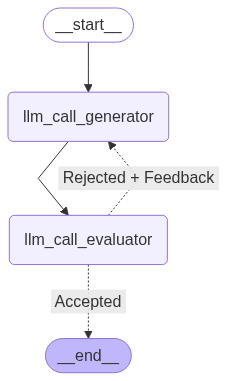

In [18]:
# Build workflow
optimizer_builder = StateGraph(State)

# Add the nodes
optimizer_builder.add_node("llm_call_generator", llm_call_generator)
optimizer_builder.add_node("llm_call_evaluator", llm_call_evaluator)

# Add edges to connect nodes
optimizer_builder.add_edge(START, "llm_call_generator")
optimizer_builder.add_edge("llm_call_generator", "llm_call_evaluator")
optimizer_builder.add_conditional_edges(
    "llm_call_evaluator",
    route_joke,
    {  # Name returned by route_joke : Name of next node to visit
        "Accepted": END,
        "Rejected + Feedback": "llm_call_generator",
    },
)

# Compile the workflow
optimizer_workflow = optimizer_builder.compile()

# Show the workflow
display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))

In [19]:
state = optimizer_workflow.invoke({"topic": "Cats"})
print(state["joke"])

2025-05-22 13:20:58,522 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-22 13:21:02,585 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"


Here's a cat joke for you:

Why don't cats like online shopping?
They prefer a cat-alog!

Alternative cat joke:
What do you call a cat that becomes a priest?
A paw-ther!
